# Ad Performance Case Study

## The situation

A company ran a Facebook ad campaign to promote a free iOS app in Brazil from October 7 to December 31, 2014.

**The app:**
- Free to install
- Makes money through in-app purchases and ads

**The campaign:**
- One creative
- Broad audience targeting
- Daily budget cap: \$90
- Platform: Facebook app installs

**The question:** to what extent was this campaign profitable? What could we do next?

## The data

We have two datasets with daily metrics:

**Campaign data** (Oct 7 – Dec 31):
- Spend
- CPM (cost per 1000 impressions)
- CTR (click-through rate)
- Paid downloads (directly attributed to ads)
- CPI (cost per install, paid only)
- ARPD (average revenue per download, day 0)
- APPD (average profit per download, day 0)

**App-wide data** (full timeline):
- Total daily downloads (all sources)
- Total daily revenue (all users)

With this data, we want to answer three questions:
1. How many installs did the campaign really create?
2. What's the true value per user?
3. Should we keep spending, and if so, how?

## What we found

**The campaign was highly profitable:**
- Cost per install: \\$0.039
- Value per install (30-day): \\$0.092
- Payback: day 0
- ROI: +138% profit per dollar spent

**Three key insights:**

1. **The campaign created far more installs than attribution shows.** When the campaign started, non-attributed downloads jumped 60×. These are real users the campaign brought in.

2. **Value takes time to realize.** Day-0 profit numbers understate true value. Users generate most revenue in the first week, but it extends to 30+ days.

3. **Tuesday is 15% more efficient than the average. Thursday/Friday are 10% less efficient than the average.** We can increase profit by shifting daily budgets toward better-performing weekdays.

**Next steps:** validate these findings with a geographical holdout test, then shift budgets by weekday and refresh creatives to address December decline.

## Key definitions

A few terms we'll use:

- **CPI** (cost per install): how much we spend per user acquired
- **LTV** (lifetime value): how much revenue a user generates over time  
- **Payback**: how long it takes for revenue to cover acquisition cost
- **Halo effect**: installs that happen because of the campaign but aren't directly attributed to it

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from pathlib import Path

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 11

# Paths
ROOT = Path.cwd().resolve()
if not (ROOT / 'data').exists():
    ROOT = ROOT.parent.resolve()

# Load clean data
ad = pd.read_csv(ROOT / 'data' / 'processed' / 'ad_data_clean.csv', parse_dates=['date'])
app = pd.read_csv(ROOT / 'data' / 'processed' / 'app_data_clean.csv', parse_dates=['date'])

# Merge on date
df = app.merge(ad, on='date', how='left')

# Campaign period flag
CAMPAIGN_START = pd.Timestamp('2014-10-07')
df['is_campaign'] = df['date'] >= CAMPAIGN_START

# Shared time features (used later for revenue/LTV + weekday analyses)
df['t'] = (df['date'] - df['date'].min()).dt.days.astype(float)
df['dow'] = df['date'].dt.dayofweek.astype(int)

print(f"App data: {len(app)} days ({app['date'].min().date()} to {app['date'].max().date()})")
print(f"Ad data: {len(ad)} days ({ad['date'].min().date()} to {ad['date'].max().date()})")
print(f"Pre-campaign days: {(~df['is_campaign']).sum()}, Campaign days: {df['is_campaign'].sum()}")

App data: 153 days (2014-08-01 to 2014-12-31)
Ad data: 86 days (2014-10-07 to 2014-12-31)
Pre-campaign days: 67, Campaign days: 86


## Question 1: How many installs did the campaign create?

The campaign data shows "paid downloads" — installs that Facebook directly attributed to ads. But is that the full story?

Let's look at what happened to total app downloads when the campaign started.

---
## Chart 1: The halo effect

When the campaign started on October 7, something interesting happened: non-attributed installs jumped from ~13/day to ~855/day.

That's a 60× increase in downloads that Facebook didn't directly attribute to our ads. This is the halo effect: real installs caused by the campaign but not credited to it.

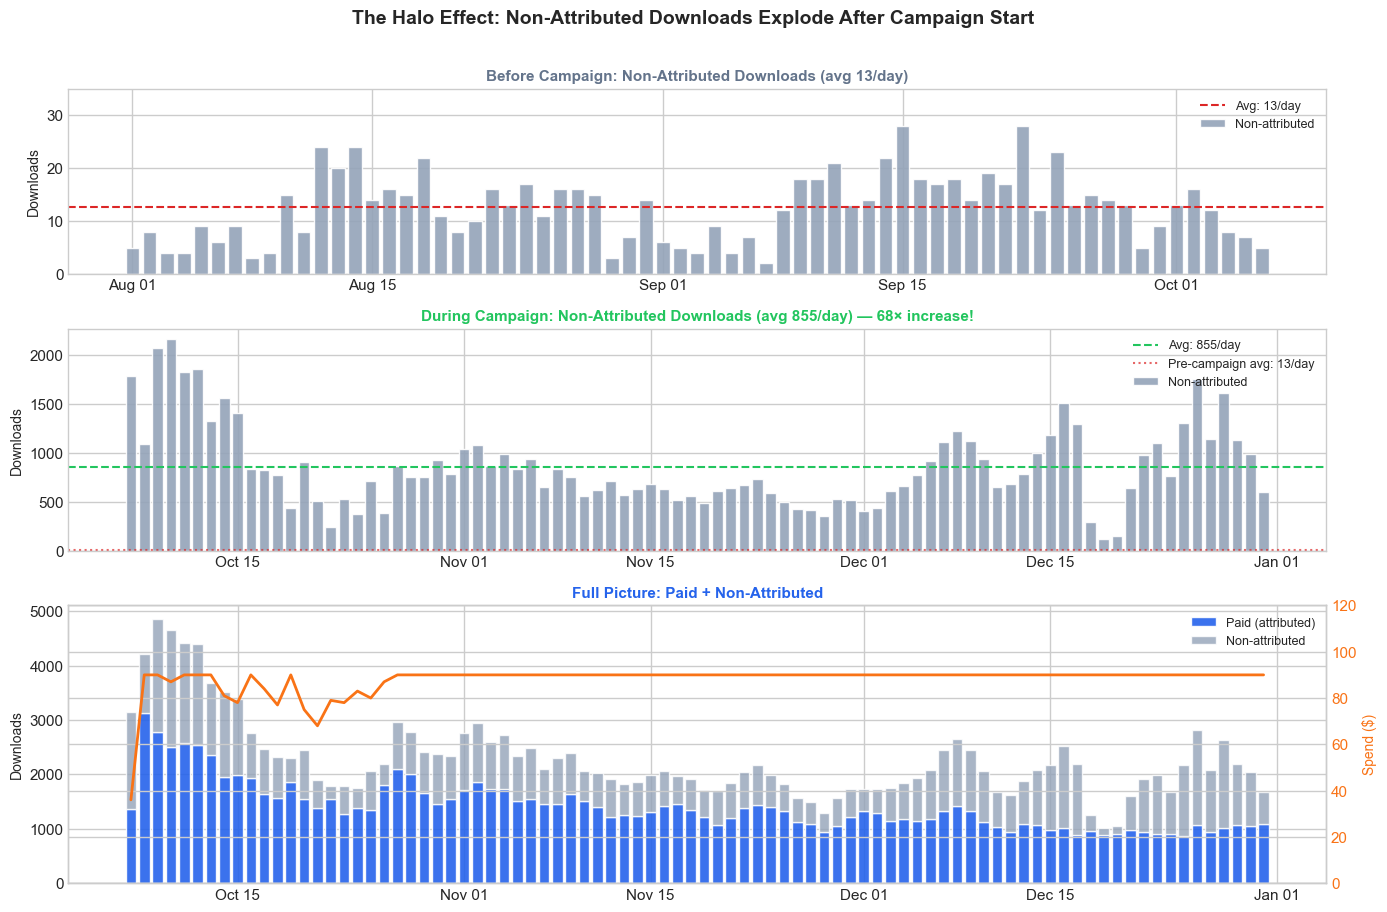

Pre-campaign non-attributed: 13/day
During campaign non-attributed: 855/day
Increase: 68x — the campaign created ~843 extra 'halo' installs/day


In [177]:
# Chart 1: Three-panel layout showing halo effect
# Top: Pre-campaign non-attributed | Middle: During-campaign non-attributed | Bottom: Full stacked

# Prepare data
plot_df = df.copy()
plot_df['paid_downloads'] = plot_df['paid_downloads'].fillna(0)
plot_df['spend'] = plot_df['spend'].fillna(0)

pre_df = plot_df[~plot_df['is_campaign']]
camp_df = plot_df[plot_df['is_campaign']]

pre_avg = pre_df['non_attributed_downloads'].mean()
camp_non_attr_avg = camp_df['non_attributed_downloads'].mean()

fig, (ax_pre, ax_mid, ax_full) = plt.subplots(3, 1, figsize=(14, 9), 
                                               gridspec_kw={'height_ratios': [1, 1.2, 1.5]})

# === TOP PANEL: Pre-campaign non-attributed ===
ax_pre.bar(pre_df['date'], pre_df['non_attributed_downloads'], 
           label='Non-attributed', color='#94a3b8', alpha=0.9, width=0.8)
ax_pre.set_ylabel('Downloads', fontsize=10)
ax_pre.set_ylim(0, 35)
ax_pre.set_title(f'Before Campaign: Non-Attributed Downloads (avg {pre_avg:.0f}/day)', 
                 fontsize=11, fontweight='bold', color='#64748b')
ax_pre.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_pre.axhline(pre_avg, color='#dc2626', linestyle='--', linewidth=1.5, 
               label=f'Avg: {pre_avg:.0f}/day')
ax_pre.legend(loc='upper right', fontsize=9)

# === MIDDLE PANEL: During-campaign non-attributed only (same scale would be misleading, use full scale) ===
ax_mid.bar(camp_df['date'], camp_df['non_attributed_downloads'], 
           label='Non-attributed', color='#94a3b8', alpha=0.9, width=0.8)
ax_mid.set_ylabel('Downloads', fontsize=10)
ax_mid.set_title(f'During Campaign: Non-Attributed Downloads (avg {camp_non_attr_avg:.0f}/day) — {camp_non_attr_avg/pre_avg:.0f}× increase!', 
                 fontsize=11, fontweight='bold', color='#22c55e')
ax_mid.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax_mid.axhline(camp_non_attr_avg, color='#22c55e', linestyle='--', linewidth=1.5, 
               label=f'Avg: {camp_non_attr_avg:.0f}/day')
ax_mid.axhline(pre_avg, color='#dc2626', linestyle=':', linewidth=1.5, alpha=0.7,
               label=f'Pre-campaign avg: {pre_avg:.0f}/day')
ax_mid.legend(loc='upper right', fontsize=9)

# === BOTTOM PANEL: Full stacked view ===
ax_full.bar(camp_df['date'], camp_df['paid_downloads'], 
            label='Paid (attributed)', color='#2563eb', alpha=0.9, width=0.8)
ax_full.bar(camp_df['date'], camp_df['non_attributed_downloads'], 
            bottom=camp_df['paid_downloads'], label='Non-attributed', color='#94a3b8', alpha=0.8, width=0.8)
ax_full.set_ylabel('Downloads', fontsize=10)
ax_full.set_xlabel('')
ax_full.set_title('Full Picture: Paid + Non-Attributed', 
                  fontsize=11, fontweight='bold', color='#2563eb')

# Spend overlay
ax_full2 = ax_full.twinx()
ax_full2.plot(camp_df['date'], camp_df['spend'], color='#f97316', linewidth=2)
ax_full2.set_ylabel('Spend ($)', color='#f97316', fontsize=10)
ax_full2.tick_params(axis='y', labelcolor='#f97316')
ax_full2.set_ylim(0, 120)

ax_full.legend(loc='upper right', fontsize=9)
ax_full.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.suptitle('The Halo Effect: Non-Attributed Downloads Explode After Campaign Start', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Summary stats
print(f"Pre-campaign non-attributed: {pre_avg:.0f}/day")
print(f"During campaign non-attributed: {camp_non_attr_avg:.0f}/day")
print(f"Increase: {camp_non_attr_avg/pre_avg:.0f}x — the campaign created ~{camp_non_attr_avg - pre_avg:.0f} extra 'halo' installs/day")


---
## Chart 2: Two ways to calculate cost per install

Since the halo is so large, we have two choices for calculating cost per install:

1. **CPI_paid**: Spend ÷ Paid downloads (what Facebook reports)
2. **CPI_all**: Spend ÷ Total downloads (includes the halo)

The real CPI lies in between these two values. In our case, since the jump on Oct 7 was so large, we can approximate the "halo" users to all non-attributed users, considering the true organic users negligible. Therefore, we will assume that the real CPI is CPI_all. 

The chart below shows both CPI_paid and CPI_all.

In [178]:
# CPI setup: in this dataset, campaign installs are approximately incremental

pre_period = df[~df['is_campaign']].copy()
camp = df[df['is_campaign']].copy()

# Calculate CPI metrics
camp['cpi_paid'] = camp['spend'] / camp['paid_downloads']
camp['cpi_all'] = camp['spend'] / camp['total_downloads']

# Working CPI for the overall campaign
CPI_WORKING = camp['spend'].sum() / camp['total_downloads'].sum()

# For chart comparisons
pre_non_attr = pre_period['non_attributed_downloads']
camp_non_attr = camp['non_attributed_downloads']

print("=== Non-attributed installs: pre vs during campaign ===")
print(f"Pre-campaign:   min={int(pre_non_attr.min()):>4d}, max={int(pre_non_attr.max()):>4d}, avg={pre_non_attr.mean():5.1f}/day")
print(f"During campaign: min={int(camp_non_attr.min()):>4d}, max={int(camp_non_attr.max()):>4d}, avg={camp_non_attr.mean():5.1f}/day")
print(f"\nIncrease: {camp_non_attr.mean() / pre_non_attr.mean():.1f}× (from ~{pre_non_attr.mean():.0f}/day to ~{camp_non_attr.mean():.0f}/day)")

# Average CPIs for chart
cpi_paid_avg = camp['cpi_paid'].mean()
cpi_all_avg = camp['cpi_all'].mean()

=== Non-attributed installs: pre vs during campaign ===
Pre-campaign:   min=   2, max=  28, avg= 12.6/day
During campaign: min= 116, max=2162, avg=855.1/day

Increase: 67.7× (from ~13/day to ~855/day)


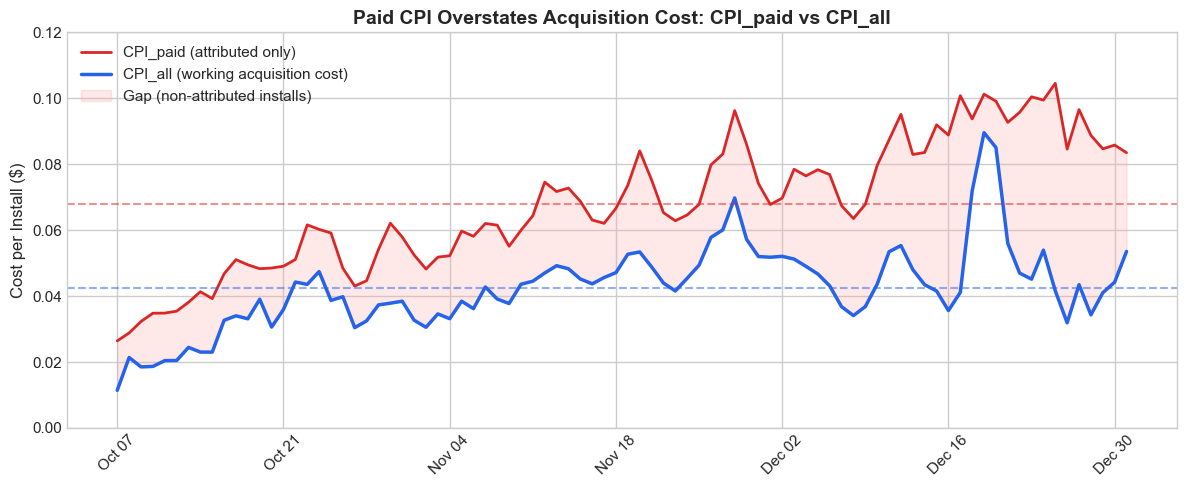

In [179]:
# Hero Chart 2: CPI_paid vs CPI_all over time

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(camp['date'], camp['cpi_paid'], label='CPI_paid (attributed only)', 
        color='#dc2626', linewidth=2)
ax.plot(camp['date'], camp['cpi_all'], label='CPI_all (working acquisition cost)', 
        color='#2563eb', linewidth=2.5)

# Visualize the gap (driven by non-attributed installs)
ax.fill_between(
    camp['date'],
    camp['cpi_all'],
    camp['cpi_paid'],
    where=(camp['cpi_paid'] >= camp['cpi_all']),
    color='#fca5a5',
    alpha=0.25,
    label='Gap (non-attributed installs)' 
)

# Campaign-average reference lines
ax.axhline(cpi_paid_avg, color='#dc2626', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(cpi_all_avg, color='#2563eb', linestyle='--', linewidth=1.5, alpha=0.5)

ax.set_ylabel('Cost per Install ($)', fontsize=12)
ax.set_xlabel('')
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
ax.set_ylim(0, 0.12)

plt.title('Paid CPI Overstates Acquisition Cost: CPI_paid vs CPI_all', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## A quick caveat

Could something else explain the jump in downloads? In theory, yes — a product update or app store feature could have coincided with our campaign start. We don't see evidence of that, but we should validate with a proper test.

Later we'll propose a geo holdout experiment to confirm these installs are truly caused by our ads.

---
## Question 2: What is the true value per user?

The campaign data shows day-0 revenue per download: \$0.0169 (ARPD in the data). But users stick around and generate revenue over time. What's the full 30-day value?

The problem: we only have daily totals. We don't have individual user data showing "user A installed on day X and generated \$Y revenue over 30 days."

**The approach:** we can infer this from the patterns in our daily data. If revenue on day $t$ comes from users who installed on day $t$, day $t-1$, day $t-2$, etc., we can mathematically work backward to estimate how much revenue a typical user generates at each age. Our assumption here is that the revenue from a user at day $k$ only depends on $k$, not on the installation date. As we will see later, this is good enough for a working estimation, but need not be totally true in the real case.

This gives us:
- Revenue per user at age 0, 1, 2, ... 30 days
- Total 30-day value per user
- Payback day (when revenue covers acquisition cost)

---
## Chart 3: Value over time

The chart below shows the estimated revenue curve. Key findings:
- Most value comes in the first week
- By day 30, the average user has generated \$0.092
- Payback happens on day 0 (revenue covers cost immediately)

In [180]:
# Incremental revenue: in this dataset, campaign-period revenue is approximately incremental
pre_rev = df.loc[~df['is_campaign'], 'total_revenue']
camp_rev = df.loc[df['is_campaign'], 'total_revenue']

print("=== Total revenue: pre vs during campaign ===")
print(f"Pre-campaign:    min=${pre_rev.min():.2f}, max=${pre_rev.max():.2f}, avg=${pre_rev.mean():.2f}/day")
print(f"During campaign: min=${camp_rev.min():.2f}, max=${camp_rev.max():.2f}, avg=${camp_rev.mean():.2f}/day")

# Working approximations for LTV modeling
df['incremental_installs'] = np.where(df['is_campaign'], df['total_downloads'].astype(float), 0.0)
df['incremental_revenue'] = np.where(df['is_campaign'], df['total_revenue'].astype(float), 0.0)

print(f"\nTotal campaign revenue (used as ΔR): ${df.loc[df['is_campaign'], 'incremental_revenue'].sum():,.2f}")

=== Total revenue: pre vs during campaign ===
Pre-campaign:    min=$0.16, max=$2.30, avg=$1.08/day
During campaign: min=$92.56, max=$366.92, avg=$199.32/day

Total campaign revenue (used as ΔR): $17,141.79


In [181]:
# Deconvolution / distributed-lag LTV estimation from aggregate time series
# Under our simplifying assumptions: I_t ≈ total installs, ΔR_t ≈ total revenue (during campaign)

MAX_LAG = 30

# Build lag design matrix using the full timeline so early-campaign lags correctly read as 0.
lag_cols = []
for k in range(MAX_LAG + 1):
    lag_cols.append(df['incremental_installs'].shift(k).fillna(0.0).to_numpy())

X = np.column_stack(lag_cols)  # shape: (days, MAX_LAG+1)
y = df['incremental_revenue'].to_numpy()

# Fit on campaign period (where our Δ assumptions apply)
mask = df['is_campaign'].to_numpy()
Xc = X[mask]
yc = y[mask]

from sklearn.linear_model import Ridge

# Non-negative ridge; intercept fixed at 0
ridge = Ridge(alpha=1.0, positive=True, fit_intercept=False)
ridge.fit(Xc, yc)

# h_k: $ per install at lag k (k=0 is same-day)
h_coeffs = ridge.coef_
ltv_cumulative = np.cumsum(h_coeffs)

# Fit diagnostics (in-sample)
yhat = ridge.predict(Xc)
ss_res = np.sum((yc - yhat) ** 2)
ss_tot = np.sum((yc - np.mean(yc)) ** 2)
r2 = 1 - ss_res / ss_tot
rmse = float(np.sqrt(np.mean((yc - yhat) ** 2)))
mae = float(np.mean(np.abs(yc - yhat)))

# Key horizons (days 0–6 = 7-day, etc.)
LTV_7 = float(ltv_cumulative[6])
LTV_14 = float(ltv_cumulative[13])
LTV_30 = float(ltv_cumulative[29])

print("=== Deconvolution (Distributed-Lag) LTV Model ===")
print(f"Fit quality on campaign period: R²={r2:.3f}, RMSE=${rmse:.1f}/day, MAE=${mae:.1f}/day")
print(f"h_0 (same-day revenue per install): ${h_coeffs[0]:.4f}")
print(f"LTV_7  (days 0–6):   ${LTV_7:.4f}")
print(f"LTV_14 (days 0–13):  ${LTV_14:.4f}")
print(f"LTV_30 (days 0–29):  ${LTV_30:.4f}")

# Simple insight: front-loaded vs long-tail value
if LTV_30 > 0:
    print(f"Share of 30-day value captured on day 0: {h_coeffs[0] / LTV_30:.0%}")
    print(f"Share of 30-day value captured by day 7: {LTV_7 / LTV_30:.0%}")

# Payback day vs working CPI
pb = np.where(ltv_cumulative >= CPI_WORKING)[0]
if len(pb) > 0:
    print(f"Payback vs CPI_working (${CPI_WORKING:.4f}): day {int(pb[0])}")
else:
    print(f"No payback within {MAX_LAG} days vs CPI_working (${CPI_WORKING:.4f})")

=== Deconvolution (Distributed-Lag) LTV Model ===
Fit quality on campaign period: R²=0.744, RMSE=$30.0/day, MAE=$23.0/day
h_0 (same-day revenue per install): $0.0582
LTV_7  (days 0–6):   $0.0803
LTV_14 (days 0–13):  $0.0854
LTV_30 (days 0–29):  $0.0924
Share of 30-day value captured on day 0: 63%
Share of 30-day value captured by day 7: 87%
Payback vs CPI_working ($0.0388): day 0


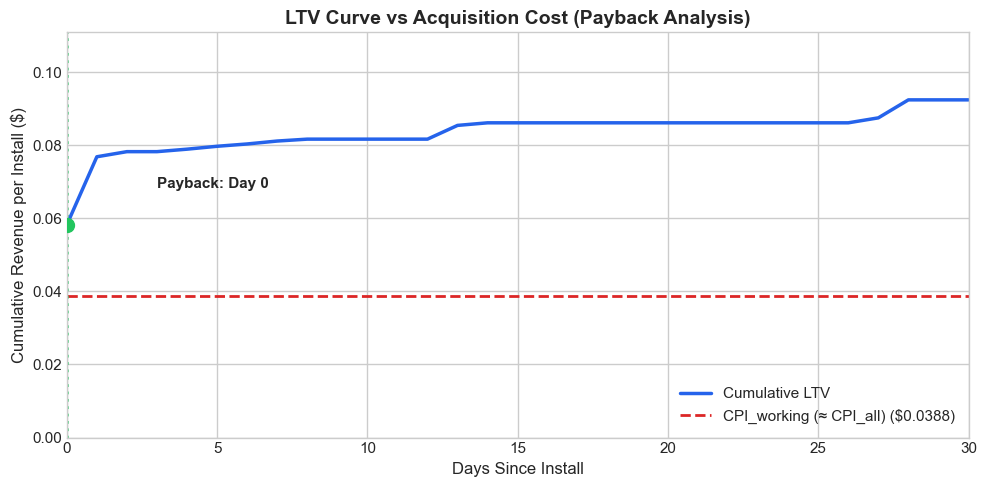


=== Payback Analysis ===
CPI_working (≈ CPI_all): $0.0388
LTV_30 (days 0–29): $0.0924
30-day ROI: 138.2%


In [182]:
# Chart 4: Cumulative LTV vs working CPI (CPI_all proxy)

fig, ax = plt.subplots(figsize=(10, 5))

days = np.arange(MAX_LAG + 1)
ax.plot(days, ltv_cumulative, color='#2563eb', linewidth=2.5, label='Cumulative LTV')
ax.axhline(CPI_WORKING, color='#dc2626', linestyle='--', linewidth=2, 
           label=f'CPI_working (≈ CPI_all) (${CPI_WORKING:.4f})')

# Find payback day
payback_day = np.where(ltv_cumulative >= CPI_WORKING)[0]
if len(payback_day) > 0:
    pb = int(payback_day[0])
    ax.axvline(pb, color='#22c55e', linestyle=':', linewidth=2, alpha=0.7)
    ax.scatter([pb], [ltv_cumulative[pb]], color='#22c55e', s=100, zorder=5)
    ax.annotate(f'Payback: Day {pb}', xy=(pb, ltv_cumulative[pb]), 
                xytext=(pb+3, ltv_cumulative[pb]+0.01), fontsize=11, fontweight='bold')

ax.set_xlabel('Days Since Install', fontsize=12)
ax.set_ylabel('Cumulative Revenue per Install ($)', fontsize=12)
ax.legend(loc='lower right')
ax.set_xlim(0, MAX_LAG)
ax.set_ylim(0, max(ltv_cumulative.max(), CPI_WORKING) * 1.2)
plt.title('LTV Curve vs Acquisition Cost (Payback Analysis)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary
print(f"\n=== Payback Analysis ===")
print(f"CPI_working (≈ CPI_all): ${CPI_WORKING:.4f}")
print(f"LTV_30 (days 0–29): ${ltv_cumulative[29]:.4f}")
print(f"30-day ROI: {(ltv_cumulative[29] / CPI_WORKING - 1) * 100:.1f}%")

---
## Chart 4: Daily profitability

Now that we have a single **LTV_30** estimate from deconvolution, we can translate it into a daily profitability view:

- **Estimated 30-day margin per install**: $\text{Margin}_t \approx LTV_{30} - CPI_{all,t}$
- **Estimated daily net profit**: $\text{Profit}_t \approx \text{TotalInstalls}_t \cdot (LTV_{30} - CPI_{all,t})$

For context, we also overlay the reported **APPD** from the raw campaign table (day-0 profit per *paid-attributed* install). This is the punchline: **day-0 paid APPD understates the campaign’s true 30-day economics**.

**Caveat:** we use a single average **LTV_30** for all cohorts. If cohort quality drifts over time (creative fatigue, audience drift, product/measurement changes), then true margin per install varies — this is our best estimate from aggregate data.

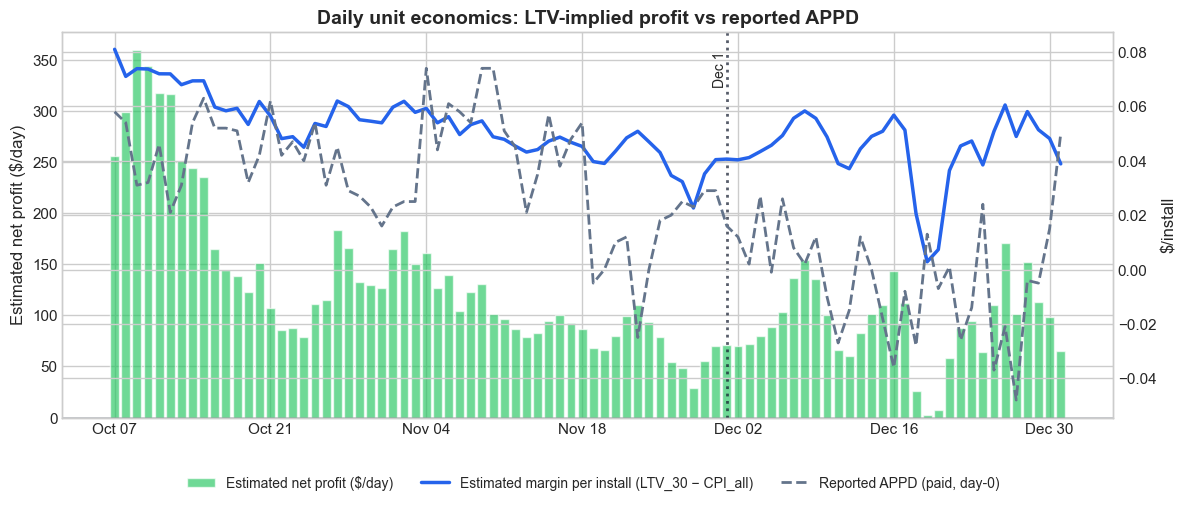

=== Chart 4 summary ===
LTV_30 estimate (single average): $0.0924 per install
Avg CPI_all: $0.0424 per install
Avg estimated 30-day margin per install: $0.0500
Avg reported APPD (paid, day-0): $0.0226
Estimated total 30-day profit over campaign: $10,456

=== Drift check (Oct–Nov vs Dec) ===
Avg CPI_all: 0.0391 → 0.0485
Avg margin/install (30d): 0.0533 → 0.0439
Avg net profit/day (30d): $139 → $92


In [183]:
# Chart 4b: Daily unit economics using a single LTV_30

camp_ux = camp.copy()

# Estimated margin per install using working CPI and a single LTV_30
camp_ux['margin_per_install_30d'] = LTV_30 - camp_ux['cpi_all']

# Estimated net profit dollars per day (profit from that day's acquired installs over 30 days)
camp_ux['net_profit_daily_30d'] = camp_ux['total_downloads'] * camp_ux['margin_per_install_30d']

DEC1 = pd.Timestamp('2014-12-01')

fig, ax1 = plt.subplots(figsize=(12, 5))

# Bars: daily net profit ($)
bar_colors = np.where(camp_ux['net_profit_daily_30d'] >= 0, '#22c55e', '#ef4444')
ax1.bar(camp_ux['date'], camp_ux['net_profit_daily_30d'], color=bar_colors, alpha=0.65, width=0.8, label='Estimated net profit ($/day)')
ax1.axhline(0, color='#0f172a', linewidth=1)
ax1.set_ylabel('Estimated net profit ($/day)', fontsize=12)

# Mark December drift
ax1.axvline(DEC1, color='#0f172a', linestyle=':', linewidth=2, alpha=0.7)
ax1.text(DEC1, ax1.get_ylim()[1] * 0.95, 'Dec 1', rotation=90, va='top', ha='right', fontsize=10)

# Lines: $ per install
ax2 = ax1.twinx()
ax2.plot(camp_ux['date'], camp_ux['margin_per_install_30d'], color='#2563eb', linewidth=2.5,
         label=f'Estimated margin per install (LTV_30 − CPI_all)')
ax2.plot(camp_ux['date'], camp_ux['appd_paid_d0'], color='#64748b', linestyle='--', linewidth=2,
         label='Reported APPD (paid, day-0)')
ax2.set_ylabel('$/install', fontsize=12)

# Combined legend (outside plot area, below)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
fig.legend(h1 + h2, l1 + l2, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3, fontsize=10)

# Formatting
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.title('Daily unit economics: LTV-implied profit vs reported APPD', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space at bottom for legend
plt.show()

# Quick summary numbers (for narration)
print("=== Chart 4 summary ===")
print(f"LTV_30 estimate (single average): ${LTV_30:.4f} per install")
print(f"Avg CPI_all: ${camp_ux['cpi_all'].mean():.4f} per install")
print(f"Avg estimated 30-day margin per install: ${camp_ux['margin_per_install_30d'].mean():.4f}")
print(f"Avg reported APPD (paid, day-0): ${camp_ux['appd_paid_d0'].mean():.4f}")
print(f"Estimated total 30-day profit over campaign: ${camp_ux['net_profit_daily_30d'].sum():,.0f}")

# Simple drift summary: Oct–Nov vs Dec
pre_dec = camp_ux[camp_ux['date'] < DEC1]
dec = camp_ux[camp_ux['date'] >= DEC1]
print("\n=== Drift check (Oct–Nov vs Dec) ===")
print(f"Avg CPI_all: {pre_dec['cpi_all'].mean():.4f} → {dec['cpi_all'].mean():.4f}")
print(f"Avg margin/install (30d): {pre_dec['margin_per_install_30d'].mean():.4f} → {dec['margin_per_install_30d'].mean():.4f}")
print(f"Avg net profit/day (30d): ${pre_dec['net_profit_daily_30d'].mean():,.0f} → ${dec['net_profit_daily_30d'].mean():,.0f}")


---
## What happened in December?

In Chart 4, the campaign’s unit economics weaken in December (lower margin per install / lower profit per day).

**Likely causes:** creative fatigue (CTR decay), audience saturation (CPI rises), auction seasonality, or product/measurement changes.

**What we do next:** refresh creatives, run a small **budget step test** to identify diminishing returns, and monitor cohort quality weekly (e.g., D0/D7/D30 revenue per install) so we can detect drift early.


---
## Question 3: Can we do better?

At this point we have two key ingredients:
- A working acquisition cost per install: **CPI_working ≈ CPI_all**
- A single value per install: **LTV_30** (from deconvolution)

This lets us define a daily profitability score:

$$ROI_{30,t} \approx \frac{LTV_{30}}{CPI_{all,t}} - 1$$

Interpretation: **profit per \$1 of spend** (over a 30‑day horizon), under the “single LTV” assumption.

### Are some weekdays more profitable than others?
There are clear signs of weekday seasonality in the charts above: some weekdays appear to be more profitable than others. If we quantify this, we could maybe adjust our daily budget to optimize these variations.

### We must compare weekdays *within weeks*
Campaign performance drifts over time (e.g., December looks weaker overall). To isolate weekday effects from slow drift, we compare days **relative to the average day in the same week** (a “week fixed‑effect” idea).

### Goal
Identify which weekdays have consistently higher **ROI** and turn that into a practical daily cap schedule (keeping weekly spend fixed). We then propose a simple real‑world test to validate before scaling.

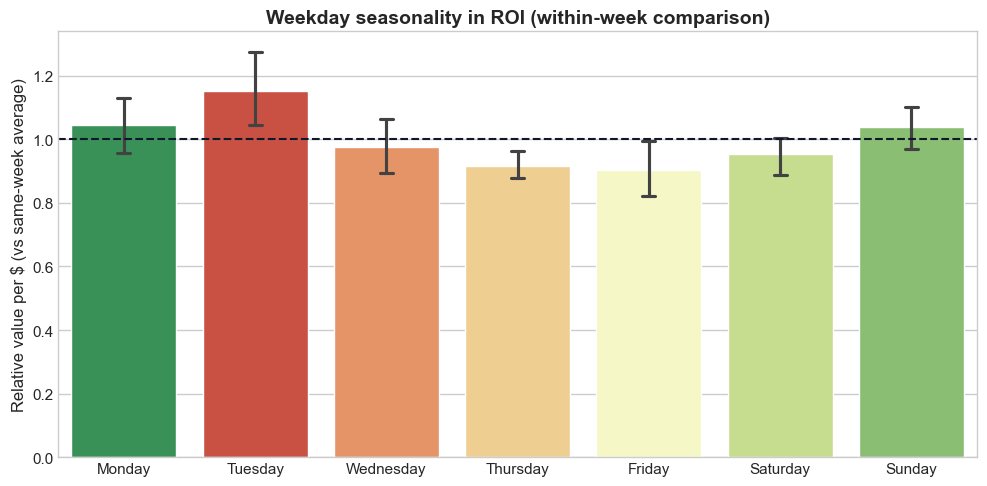


=== Weekday ROI analysis (within-week comparison) ===
           rel_value_per_$ (mean)  95% CI (±)  recommended_daily_cap_$  cap_multiplier_vs_flat
dow_name                                                                                      
Monday                      1.046       0.087                     94.0                    1.05
Tuesday                     1.153       0.121                    104.0                    1.15
Wednesday                   0.976       0.090                     88.0                    0.98
Thursday                    0.917       0.043                     83.0                    0.92
Friday                      0.904       0.087                     81.0                    0.91
Saturday                    0.955       0.065                     86.0                    0.96
Sunday                      1.038       0.070                     94.0                    1.04

Best day: Tuesday (1.15× multiplier, $104/day cap)
Weakest: Thu/Fri (0.91–0.92× multiplie

In [186]:
# Weekday ROI seasonality analysis (campaign period)

camp_seas = camp.copy()

# Daily ROI per $ spent (30-day horizon)
camp_seas['roi_30'] = (LTV_30 / camp_seas['cpi_all']) - 1
camp_seas['value_per_dollar_30'] = (LTV_30 / camp_seas['cpi_all'])  # revenue per $ (30-day)

# Weekday + week identifiers
camp_seas['dow_name'] = camp_seas['date'].dt.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Week fixed-effect idea: compare within the same week to remove slow drift
camp_seas['week_start'] = camp_seas['date'].dt.to_period('W-MON').apply(lambda p: p.start_time)
week_mean = camp_seas.groupby('week_start')['value_per_dollar_30'].transform('mean')
camp_seas['rel_value_per_dollar'] = camp_seas['value_per_dollar_30'] / week_mean
camp_seas['rel_roi_30'] = camp_seas['rel_value_per_dollar'] - 1

# === Chart: weekday effects (within-week) ===
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    data=camp_seas,
    x='dow_name',
    y='rel_value_per_dollar',
    hue='dow_name',
    order=order,
    ax=ax,
    palette='RdYlGn',
    errorbar=('ci', 95),
    capsize=0.1,
    legend=False,
)

ax.axhline(1.0, color='#0f172a', linestyle='--', linewidth=1.5)
ax.set_xlabel('')
ax.set_ylabel('Relative value per $ (vs same-week average)', fontsize=12)
ax.set_title('Weekday seasonality in ROI (within-week comparison)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table + cap allocation rule
summary = camp_seas.groupby('dow_name')['rel_value_per_dollar'].agg(['mean', 'std', 'count']).reindex(order)
summary['se'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = 1.96 * summary['se']

# Budget-cap rule: allocate weekly spend proportional to relative value per $.
# Scale weights so the 7 daily multipliers sum to 7 (weekly spend unchanged vs flat caps).
weights = summary['mean'].copy()
weights = weights * 7.0 / weights.sum()

BASE_CAP = 90.0
caps = BASE_CAP * weights

out = pd.DataFrame({
    'rel_value_per_$ (mean)': summary['mean'],
    '95% CI (±)': summary['ci95'],
    'recommended_daily_cap_$': caps,
    'cap_multiplier_vs_flat': caps / BASE_CAP,
}).round({'rel_value_per_$ (mean)': 3, '95% CI (±)': 3, 'recommended_daily_cap_$': 0, 'cap_multiplier_vs_flat': 2})

# Show the weekday analysis results
print("\n=== Weekday ROI analysis (within-week comparison) ===")
print(out.to_string())
print(f"\nBest day: Tuesday (1.15× multiplier, ${int(out.loc['Tuesday', 'recommended_daily_cap_$'])}/day cap)")
print(f"Weakest: Thu/Fri (0.91–0.92× multiplier, $81–83/day caps)")
print(f"Weekly spend stays the same: 7 × $90 = ${7*90}")


### Result → Action → Test

**Result :** Tuesday is consistently the best day (~**+15%** value per $ vs the same-week average). Thursday/Friday are the weakest (~**−8% to −10%**).

**Action (daily caps, weekly spend unchanged):**
- Tue **1.15×** (\$104)
- Mon **1.05×** (\$94)
- Sun **1.04×** (\$94)
- Wed **0.98×** (\$88)
- Sat **0.96×** (\$86)
- Thu **0.92×** (\$83)
- Fri **0.91×** (\$81)

**Test (before scaling):** alternate weeks between flat caps ($\$90$/day) vs weekday-weighted caps above; compare CPI_all, installs/$ \$ $, and revenue/$ \$ $.

**Caveat:** moving spend can change ROI (diminishing returns), so multipliers should be tuned based on the experiment results.


---
## Limitations

1. **No randomized control group**: We’re using a large step-change argument (and simple approximations like CPI_working ≈ CPI_all), not a true experiment. Confounders (seasonality shocks, product changes) could bias results.

2. **Aggregate data only**: LTV is inferred from daily totals via deconvolution (distributed-lag regression), not tracked directly at the user/cohort level.

3. **Time-varying cohort quality**: The model assumes one shared revenue-by-age curve $h_k$ across cohorts. If cohort value changes over time (creative fatigue, audience drift, product changes), the estimated LTV can be biased.

4. **Attribution is imperfect**: “Non-attributed” includes both true halo installs and measurement gaps.

5. **Truncated horizon**: Data ends Dec 31, so long-tail revenue beyond the horizon we estimate is not observed.

6. **Single creative / single geo**: Results may not generalize to other campaigns.

---
## Recommended Next Steps

### Validate
1. **Geo holdout lift test**: Run ads in some states/cities but not others; measure lift in installs and revenue. This converts our model-based story into a causal estimate.

### Operate
2. **Weekday-cap experiment**: Keep weekly spend constant, but shift daily caps using the weekday weights (flat vs weighted caps on alternating weeks). Monitor CPI_all and revenue/$.
3. **Creative refresh cadence**: December drift suggests creative fatigue/saturation. Rotate new creatives weekly and track CPI_all + margin per install.

### Measure
We used deconvolution because we only have **aggregate daily totals**. To make LTV (and channel differences) defensible, collect cohort/source data:

4. **Cohort LTV tracking by source**: For each install cohort (day), track revenue by user age (D0…D30/D90) split by **paid vs non-attributed**. This directly tests, for instance, whether non-attributed users are higher value.

### Scale
5. **Budget step test**: Run different daily caps in matched geos to map diminishing returns (ROI vs spend).
6. **Value-optimized bidding**: If Facebook supports it, optimize for high-LTV users, not just installs.